# Model Explainers - For Classification

- TO DO:
- This will come after the lesson on converting regression task to classification


## ADMIN: References
- REF: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html

## Lesson Objectives

By the end of this lesson students will be able to:
- Define a global vs local explanation
- Use the Shap package and interpret shap values.


## Model Explainers

- There are packages with the sole purpose of better understanding how machine learning models make their predictions.
- Generally, model explainers will take the model and some of your data and apply some iterative process to try to quantify how the features are influencing the model's output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.base import clone

## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

In [2]:
## Adding folder above to path
import os, sys
sys.path.append(os.path.abspath('../../'))

## Load stack_functions with autoreload turned on
%load_ext autoreload
%autoreload 2
from CODE import stack_functions as sf
from CODE import prisoner_project_functions as pf

def show_code(function):
    import inspect 
    from IPython.display import display,Markdown, display_markdown
    code = inspect.getsource(function)
    md_txt = f"```python\n{code}\n```"
    return display(Markdown(md_txt))
    

In [3]:
# show_code(pf.evaluate_classification)

## DATASET - `NEED TO FINALIZE`

### Preprocessing Titanic

In [4]:
## Load in the King's County housing dataset and display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-por')
# df.drop(columns=['G1','G2'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      649 non-null    object 
 1   sex         649 non-null    object 
 2   age         649 non-null    float64
 3   address     649 non-null    object 
 4   famsize     649 non-null    object 
 5   Pstatus     649 non-null    object 
 6   Medu        649 non-null    float64
 7   Fedu        649 non-null    float64
 8   Mjob        649 non-null    object 
 9   Fjob        649 non-null    object 
 10  reason      649 non-null    object 
 11  guardian    649 non-null    object 
 12  traveltime  649 non-null    float64
 13  studytime   649 non-null    float64
 14  failures    649 non-null    float64
 15  schoolsup   649 non-null    object 
 16  famsup      649 non-null    object 
 17  paid        649 non-null    object 
 18  activities  649 non-null    object 
 19  nursery     649 non-null    o

school sex   age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F  18.0       U     GT3       A   4.0   4.0  at_home   teacher   
1     GP   F  17.0       U     GT3       T   1.0   1.0  at_home     other   
2     GP   F  15.0       U     LE3       T   1.0   1.0  at_home     other   
3     GP   F  15.0       U     GT3       T   4.0   2.0   health  services   
4     GP   F  16.0       U     GT3       T   3.0   3.0    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother         2.0        2.0       0.0       yes     no   no   
1  course   father         1.0        2.0       0.0        no    yes   no   
2   other   mother         1.0        2.0       0.0       yes     no   no   
3    home   mother         1.0        3.0       0.0        no    yes   no   
4    home   father         1.0        2.0       0.0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no     4.0       3.0    4.0   1.0   
1         no      no    yes      yes       no     5.0       3.0    3.0   1.0   
2         no     yes    yes      yes       no     4.0       3.0    2.0   2.0   
3        yes     yes    yes      yes      yes     3.0       2.0    2.0   1.0   
4         no     yes    yes       no       no     4.0       3.0    2.0   1.0   

   Walc  health  absences    G1    G2    G3  
0   1.0     3.0       4.0   0.0  11.0  11.0  
1   1.0     3.0       2.0   9.0  11.0  11.0  
2   3.0     3.0       6.0  12.0  13.0  12.0  
3   1.0     5.0       0.0  14.0  14.0  14.0  
4   2.0     5.0       0.0  11.0  13.0  13.0

## QUICK CONVERT TO CLASS

- Maybe curve grades? 
    - https://www.wikihow.com/Curve-Grades
- Or just make letter grades?



In [5]:
grade_cols = ['G1','G2','G3']
for col in grade_cols:
    df[f"{col}(%)"] = (df[col]/20) *100
# df[['G1%','G2%','G3%']]  = df[['G1','G2','G3']]/20*100
df

school sex   age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F  18.0       U     GT3       A   4.0   4.0   at_home   teacher   
1       GP   F  17.0       U     GT3       T   1.0   1.0   at_home     other   
2       GP   F  15.0       U     LE3       T   1.0   1.0   at_home     other   
3       GP   F  15.0       U     GT3       T   4.0   2.0    health  services   
4       GP   F  16.0       U     GT3       T   3.0   3.0     other     other   
..     ...  ..   ...     ...     ...     ...   ...   ...       ...       ...   
644     MS   F  19.0       R     GT3       T   2.0   3.0  services     other   
645     MS   F  18.0       U     LE3       T   3.0   1.0   teacher  services   
646     MS   F  18.0       U     GT3       T   1.0   1.0     other     other   
647     MS   M  17.0       U     LE3       T   3.0   1.0  services  services   
648     MS   M  18.0       R     LE3       T   3.0   2.0  services     other   

     reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0    course   mother         2.0        2.0       0.0       yes     no   no   
1    course   father         1.0        2.0       0.0        no    yes   no   
2     other   mother         1.0        2.0       0.0       yes     no   no   
3      home   mother         1.0        3.0       0.0        no    yes   no   
4      home   father         1.0        2.0       0.0        no    yes   no   
..      ...      ...         ...        ...       ...       ...    ...  ...   
644  course   mother         1.0        3.0       1.0        no     no   no   
645  course   mother         1.0        2.0       0.0        no    yes   no   
646  course   mother         2.0        2.0       0.0        no     no   no   
647  course   mother         2.0        1.0       0.0        no     no   no   
648  course   mother         3.0        1.0       0.0        no     no   no   

    activities nursery higher internet romantic  famrel  freetime  goout  \
0           no     yes    yes       no       no     4.0       3.0    4.0   
1           no      no    yes      yes       no     5.0       3.0    3.0   
2           no     yes    yes      yes       no     4.0       3.0    2.0   
3          yes     yes    yes      yes      yes     3.0       2.0    2.0   
4           no     yes    yes       no       no     4.0       3.0    2.0   
..         ...     ...    ...      ...      ...     ...       ...    ...   
644        yes      no    yes      yes       no     5.0       4.0    2.0   
645         no     yes    yes      yes       no     4.0       3.0    4.0   
646        yes     yes    yes       no       no     1.0       1.0    1.0   
647         no      no    yes      yes       no     2.0       4.0    5.0   
648         no      no    yes      yes       no     4.0       4.0    1.0   

     Dalc  Walc  health  absences    G1    G2    G3  G1(%)  G2(%)  G3(%)  
0     1.0   1.0     3.0       4.0   0.0  11.0  11.0    0.0   55.0   55.0  
1     1.0   1.0     3.0       2.0   9.0  11.0  11.0   45.0   55.0   55.0  
2     2.0   3.0     3.0       6.0  12.0  13.0  12.0   60.0   65.0   60.0  
3     1.0   1.0     5.0       0.0  14.0  14.0  14.0   70.0   70.0   70.0  
4     1.0   2.0     5.0       0.0  11.0  13.0  13.0   55.0   65.0   65.0  
..    ...   ...     ...       ...   ...   ...   ...    ...    ...    ...  
644   1.0   2.0     5.0       4.0  10.0  11.0  10.0   50.0   55.0   50.0  
645   1.0   1.0     1.0       4.0  15.0  15.0  16.0   75.0   75.0   80.0  
646   1.0   1.0     5.0       6.0  11.0  12.0   9.0   55.0   60.0   45.0  
647   3.0   4.0     2.0       6.0  10.0  10.0  10.0   50.0   50.0   50.0  
648   3.0   4.0     5.0       4.0  10.0  11.0  11.0   50.0   55.0   55.0  

[649 rows x 36 columns]

In [6]:
x = df['G3(%)'].values
x

array([55., 55., 60., 70., 65., 65., 65., 65., 85., 65., 70., 65., 60.,
       65., 75., 85., 70., 70., 35., 60., 70., 60., 70., 50., 50., 60.,
       60., 55., 65., 60., 55., 75., 75., 60., 60., 55., 70., 65., 60.,
       60., 50., 55., 75., 50., 55., 55., 65., 85., 65., 60., 65., 80.,
       45., 60., 65., 60., 75., 80., 70., 80., 80., 80., 50., 65., 60.,
       80., 60., 50., 55., 75., 55., 50., 55., 70., 55., 55., 55., 65.,
       50., 55., 60., 45., 55., 65., 60., 60., 55., 75., 55., 50., 55.,
       65., 60., 70., 60., 65., 55., 60., 65., 65., 40., 80., 60., 50.,
       80., 50., 50., 70., 55., 70., 70., 55., 50., 90., 50., 70., 80.,
       75., 55., 70., 70., 65., 65., 65., 55., 45., 55., 55., 75., 65.,
       60., 40., 55., 65., 60., 70., 55., 55., 55., 75., 50., 65., 60.,
       55., 55., 50., 50., 70., 45., 55., 45., 65., 55., 65., 55., 30.,
       60., 50., 55., 65., 55., 40., 55.,  0., 50., 65., 55., 65., 40.,
       50., 55., 55.,  5., 50., 45., 40., 50., 40., 40., 40., 55

In [7]:
def calc_letter_grade(x):
    if isinstance(x,pd.Series):
        x = x.values
    letter_grades = {'A':x>=90,
                'B':(80<=x)&(x<90),
                'C':(70<=x)&(x<80),
                'D':(60<=x)&(x<70),
                'F':x<60}
    return np.select(letter_grades.values(), letter_grades.keys())

In [8]:
calc_letter_grade(df['G3(%)'])

array(['F', 'F', 'D', 'C', 'D', 'D', 'D', 'D', 'B', 'D', 'C', 'D', 'D',
       'D', 'C', 'B', 'C', 'C', 'F', 'D', 'C', 'D', 'C', 'F', 'F', 'D',
       'D', 'F', 'D', 'D', 'F', 'C', 'C', 'D', 'D', 'F', 'C', 'D', 'D',
       'D', 'F', 'F', 'C', 'F', 'F', 'F', 'D', 'B', 'D', 'D', 'D', 'B',
       'F', 'D', 'D', 'D', 'C', 'B', 'C', 'B', 'B', 'B', 'F', 'D', 'D',
       'B', 'D', 'F', 'F', 'C', 'F', 'F', 'F', 'C', 'F', 'F', 'F', 'D',
       'F', 'F', 'D', 'F', 'F', 'D', 'D', 'D', 'F', 'C', 'F', 'F', 'F',
       'D', 'D', 'C', 'D', 'D', 'F', 'D', 'D', 'D', 'F', 'B', 'D', 'F',
       'B', 'F', 'F', 'C', 'F', 'C', 'C', 'F', 'F', 'A', 'F', 'C', 'B',
       'C', 'F', 'C', 'C', 'D', 'D', 'D', 'F', 'F', 'F', 'F', 'C', 'D',
       'D', 'F', 'F', 'D', 'D', 'C', 'F', 'F', 'F', 'C', 'F', 'D', 'D',
       'F', 'F', 'F', 'F', 'C', 'F', 'F', 'F', 'D', 'F', 'D', 'F', 'F',
       'D', 'F', 'F', 'D', 'F', 'F', 'F', 'F', 'F', 'D', 'F', 'D', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F

In [9]:
# letter_grades = {'A':x>=90,
#                 'B':(80<=x)&(x<90),
#                 'C':(70<=x)&(x<80),
#                 'D':(60<=x)&(x<70),
#                 'F':x<60}
# np.select(letter_grades.values(), letter_grades.keys())

In [10]:
grade_cols_perc = [f"{col}(%)" for col in grade_cols]
df[grade_cols_perc]

G1(%)  G2(%)  G3(%)
0      0.0   55.0   55.0
1     45.0   55.0   55.0
2     60.0   65.0   60.0
3     70.0   70.0   70.0
4     55.0   65.0   65.0
..     ...    ...    ...
644   50.0   55.0   50.0
645   75.0   75.0   80.0
646   55.0   60.0   45.0
647   50.0   50.0   50.0
648   50.0   55.0   55.0

[649 rows x 3 columns]

In [11]:
for col in grade_cols_perc:
    df[col.replace("(%)",'_Class')] = calc_letter_grade(df[col])
df

school sex   age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F  18.0       U     GT3       A   4.0   4.0   at_home   teacher   
1       GP   F  17.0       U     GT3       T   1.0   1.0   at_home     other   
2       GP   F  15.0       U     LE3       T   1.0   1.0   at_home     other   
3       GP   F  15.0       U     GT3       T   4.0   2.0    health  services   
4       GP   F  16.0       U     GT3       T   3.0   3.0     other     other   
..     ...  ..   ...     ...     ...     ...   ...   ...       ...       ...   
644     MS   F  19.0       R     GT3       T   2.0   3.0  services     other   
645     MS   F  18.0       U     LE3       T   3.0   1.0   teacher  services   
646     MS   F  18.0       U     GT3       T   1.0   1.0     other     other   
647     MS   M  17.0       U     LE3       T   3.0   1.0  services  services   
648     MS   M  18.0       R     LE3       T   3.0   2.0  services     other   

     reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0    course   mother         2.0        2.0       0.0       yes     no   no   
1    course   father         1.0        2.0       0.0        no    yes   no   
2     other   mother         1.0        2.0       0.0       yes     no   no   
3      home   mother         1.0        3.0       0.0        no    yes   no   
4      home   father         1.0        2.0       0.0        no    yes   no   
..      ...      ...         ...        ...       ...       ...    ...  ...   
644  course   mother         1.0        3.0       1.0        no     no   no   
645  course   mother         1.0        2.0       0.0        no    yes   no   
646  course   mother         2.0        2.0       0.0        no     no   no   
647  course   mother         2.0        1.0       0.0        no     no   no   
648  course   mother         3.0        1.0       0.0        no     no   no   

    activities nursery higher internet romantic  famrel  freetime  goout  \
0           no     yes    yes       no       no     4.0       3.0    4.0   
1           no      no    yes      yes       no     5.0       3.0    3.0   
2           no     yes    yes      yes       no     4.0       3.0    2.0   
3          yes     yes    yes      yes      yes     3.0       2.0    2.0   
4           no     yes    yes       no       no     4.0       3.0    2.0   
..         ...     ...    ...      ...      ...     ...       ...    ...   
644        yes      no    yes      yes       no     5.0       4.0    2.0   
645         no     yes    yes      yes       no     4.0       3.0    4.0   
646        yes     yes    yes       no       no     1.0       1.0    1.0   
647         no      no    yes      yes       no     2.0       4.0    5.0   
648         no      no    yes      yes       no     4.0       4.0    1.0   

     Dalc  Walc  health  absences    G1    G2    G3  G1(%)  G2(%)  G3(%)  \
0     1.0   1.0     3.0       4.0   0.0  11.0  11.0    0.0   55.0   55.0   
1     1.0   1.0     3.0       2.0   9.0  11.0  11.0   45.0   55.0   55.0   
2     2.0   3.0     3.0       6.0  12.0  13.0  12.0   60.0   65.0   60.0   
3     1.0   1.0     5.0       0.0  14.0  14.0  14.0   70.0   70.0   70.0   
4     1.0   2.0     5.0       0.0  11.0  13.0  13.0   55.0   65.0   65.0   
..    ...   ...     ...       ...   ...   ...   ...    ...    ...    ...   
644   1.0   2.0     5.0       4.0  10.0  11.0  10.0   50.0   55.0   50.0   
645   1.0   1.0     1.0       4.0  15.0  15.0  16.0   75.0   75.0   80.0   
646   1.0   1.0     5.0       6.0  11.0  12.0   9.0   55.0   60.0   45.0   
647   3.0   4.0     2.0       6.0  10.0  10.0  10.0   50.0   50.0   50.0   
648   3.0   4.0     5.0       4.0  10.0  11.0  11.0   50.0   55.0   55.0   

    G1_Class G2_Class G3_Class  
0          F        F        F  
1          F        F        F  
2          D        D        D  
3          C        C        C  
4          F        D        D  
..       ...      ...      ...  
644        F        F        F  
645 

<AxesSubplot:xlabel='G3_Class', ylabel='count'>

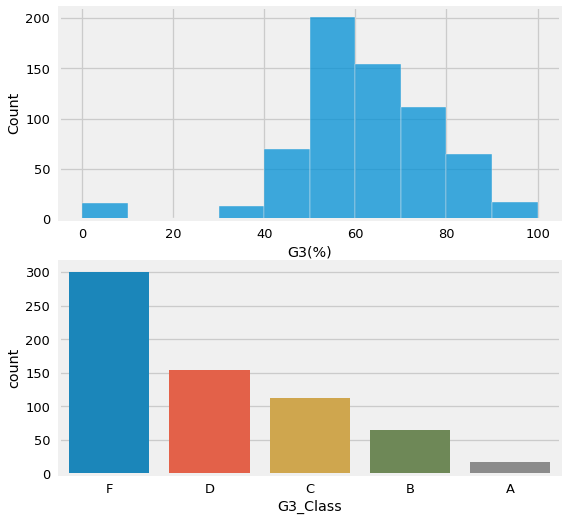

In [12]:
fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10)

sns.countplot(data=df,x='G3_Class',ax=axes[1],order=['F','D','C','B','A'])

In [13]:
df['G3_Class'].value_counts()

F    301
D    154
C    112
B     65
A     17
Name: G3_Class, dtype: int64

In [14]:
## Define target as had a F or Above
df['target_F'] = df['G3_Class'] == 'F'
df['target_F'].value_counts()

False    348
True     301
Name: target_F, dtype: int64

In [15]:
g_cols = [c for c in df.columns if c.startswith("G")]
g_cols

['G1',
 'G2',
 'G3',
 'G1(%)',
 'G2(%)',
 'G3(%)',
 'G1_Class',
 'G2_Class',
 'G3_Class']

In [16]:
# ### Train Test Split
## Make x and y variables
drop_feats = [*g_cols]
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
104  15.0   3.0   4.0         1.0        2.0       0.0     5.0       4.0   
284  18.0   2.0   1.0         1.0        1.0       2.0     3.0       2.0   
579  18.0   1.0   3.0         1.0        1.0       0.0     4.0       3.0   

     goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
104    4.0   1.0   1.0     1.0       0.0        0.0    1.0        1.0   
284    5.0   2.0   5.0     5.0       4.0        0.0    1.0        1.0   
579    3.0   2.0   3.0     3.0       0.0        1.0    1.0        1.0   

     famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
104          0.0        0.0           0.0          0.0         0.0   
284          0.0        1.0           0.0          0.0         0.0   
579          1.0        1.0           1.0          0.0         0.0   

     Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
104            1.0           0.0           0.0          0.0         1.0   
284            1.0           0.0           0.0          0.0         0.0   
579            0.0           0.0           0.0          0.0         0.0   

     Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
104            0.0           0.0            1.0          0.0           0.0   
284            1.0           0.0            0.0          0.0           1.0   
579            1.0           0.0            1.0          0.0           0.0   

     reason_reputation  guardian_father  guardian_mother  guardian_other  \
104                0.0              0.0              1.0             0.0   
284                0.0              0.0              1.0             0.0   
579                0.0              0.0              1.0             0.0   

     schoolsup_yes  famsup_yes  paid_yes  activities_yes  nursery_yes  \
104            0.0         1.0       0.0             1.0          1.0   
284            0.0         0.0       0.0             0.0          0.0   
579            0.0         0.0       0.0             0.0          1.0   

     higher_yes  internet_yes  romantic_yes  
104         1.0           1.0           0.0  
284         0.0           1.0           0.0  
579         0.0           1.0           1.0

------------------------------------------------------------
	CLASSIFICATION REPORT - Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.78      0.85      0.82        88
        True       0.81      0.72      0.76        75

    accuracy                           0.79       163
   macro avg       0.79      0.79      0.79       163
weighted avg       0.79      0.79      0.79       163



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


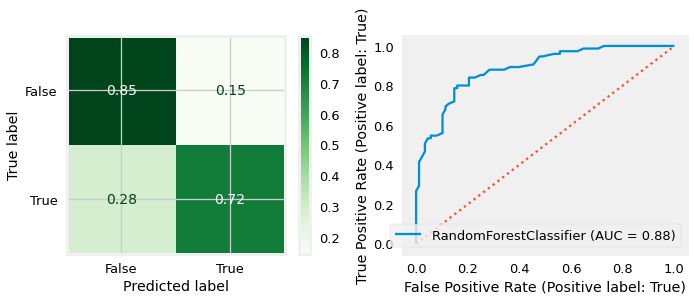

Training Score = 1.00
Test Score = 0.79


In [17]:
## fit random fores
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df,y_train)
sf.evaluate_classification(rf_clf,X_test_df,y_test, 
                       X_train=X_train_df, y_train=y_train)#linreg(rf_reg,X_train_zips,y_train,X_test_zips,y_test)

### Loading Joblib of Regressions from Lesson 04

In [18]:
# import joblib
# ## If showing joblib in prior lesson, this cell will be included and further explained
# loaded_data = joblib.load("../4_Feature_Importance/lesson_04.joblib")
# loaded_data.keys()

In [19]:
# ## If showing joblib in prior lesson, this cell will be included and further explained
# X_train_reg = loaded_data['X_train'].copy()
# y_train_reg = loaded_data['y_train'].copy()
# X_test_df_reg = loaded_data['X_test'].copy()
# y_test_reg = loaded_data['y_test'].copy()
# lin_reg = loaded_data['lin_reg']
# rf_reg = loaded_data['rf_reg']


## Using SHAP for Model Interpretation

- SHAP (SHapley Additive exPlanations)) 
    - [Repository](https://github.com/slundberg/shap)
    - [Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
  

- SHAP uses game theory to calcualte Shapely values for each feature in the dataset. 
- Shapely values are calculated by iteratively testing each feature's contribution to the model by comparing the model's  performance with vs. without the feature. (The "marginal contribution" of the feature to the model's performance).

#### Papers, Book Excerpts, and  Blogs
- [White Paper on Shapely Values](https://arxiv.org/abs/1705.07874)
    
- [Intepretable Machine Learning Book - Section on SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)
    
- Towards Data Science Blog Posts:
    - [Explain Your Model with SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

    - [Explain Any Model with SHAP KernelExplaibner](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

#### Videos/Talks:
- Explaining Machine Learning Models (in general).
    - ["Open the Black Box: an intro to Model Interpretability with LIME and SHAP](https://youtu.be/C80SQe16Rao)
- Understanding Shapely/SHAP Values:
    - [AI Simplified: SHAP Values in Machine Learning ](https://youtu.be/Tg8aPwPPJ9c)- (Intuitive Explanation)
    - [Explainable AI explained! | #4 SHAP  ](https://youtu.be/9haIOplEIGM)- (Math Calculation Explanation)

### How To Use Shap


- Import and initialize javascript:

```python
import shap 
shap.initjs()
```

In [20]:
import shap
shap.initjs()

### Shap Explainers

- shap has several types of model explainers that are optimized for different types of models. 


#### Explainers and their use cases:


| Explainer                         | Description                                                                                    |
|:----------------------------------|:-----------------------------------------------------------------------------------------------|
| shap.Explainer                    | Uses Shapley values to explain any machine learning model or python function.                  |
| shap.explainers.Tree              | Uses Tree SHAP algorithms to explain the output of ensemble tree models.                       |
| shap.explainers.Linear            | Computes SHAP values for a linear model, optionally accounting for inter-feature correlations. |
| shap.explainers.Permutation       | This method approximates the Shapley values by iterating through permutations of the inputs.   |
| shap.explainers.Sampling          | This is an extension of the Shapley sampling values explanation method (aka.                   |
| shap.explainers.Additive          | Computes SHAP values for generalized additive models.                                          |
| shap.explainers.other.Coefficent  | Simply returns the model coefficents as the feature attributions.                              |
| shap.explainers.other.Random      | Simply returns random (normally distributed) feature attributions.                             |
| shap.explainers.other.LimeTabular | Simply wrap of lime.lime_tabular.LimeTabularExplainer into the common shap interface.          |
| shap.explainers.other.Maple       | Simply wraps MAPLE into the common SHAP interface.                                             |
| shap.explainers.other.TreeMaple   | Simply tree MAPLE into the common SHAP interface.                                              |
| shap.explainers.other.TreeGain    | Simply returns the global gain/gini feature importances for tree models.                       |

<!-- - Uses game theory to explain feature importance and how a feature steered a model's prediction(s) by removing each feature and seeing the effect on the error.

- SHAP has:
    - `TreeExplainer`:
        - compatible with sckit learn, xgboost, Catboost
    - `KernelExplainer`:
        - compatible with "any" model
         -->


- See [this blog post](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) for intro to topic and how to use with trees

- For non-tree/random forest models [see this follow up post]( https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

        

### Preparing Data for Shap

- Shap's approach to explaining models can be very resource-intensive for complex models such as our RandomForest.
- To get around this issue, shap includes a convenient smapling function to save a small sample from one of our X variables.

In [21]:
X_shap = shap.sample(X_train_df,nsamples=200,random_state=321)
X_shap

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
473  16.0   2.0   1.0         2.0        1.0       0.0     2.0       4.0   
340  17.0   3.0   3.0         1.0        1.0       0.0     4.0       4.0   
452  16.0   2.0   2.0         3.0        2.0       0.0     4.0       4.0   
555  16.0   1.0   2.0         1.0        3.0       0.0     4.0       3.0   
70   16.0   3.0   1.0         2.0        4.0       0.0     4.0       3.0   
..    ...   ...   ...         ...        ...       ...     ...       ...   
353  18.0   1.0   4.0         1.0        2.0       0.0     3.0       4.0   
443  15.0   4.0   1.0         1.0        2.0       0.0     5.0       3.0   
120  15.0   1.0   2.0         1.0        2.0       0.0     3.0       2.0   
294  18.0   2.0   2.0         1.0        2.0       0.0     3.0       2.0   
340  17.0   3.0   3.0         1.0        1.0       0.0     4.0       4.0   

     goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
473    3.0   2.0   3.0     4.0       4.0        1.0    1.0        1.0   
340    3.0   1.0   3.0     5.0       0.0        0.0    1.0        1.0   
452    5.0   1.0   1.0     4.0       4.0        1.0    0.0        0.0   
555    4.0   1.0   1.0     3.0       5.0        1.0    0.0        0.0   
70     2.0   1.0   1.0     5.0       2.0        0.0    1.0        1.0   
..     ...   ...   ...     ...       ...        ...    ...        ...   
353    4.0   1.0   2.0     5.0       2.0        0.0    0.0        1.0   
443    4.0   1.0   2.0     2.0       7.0        1.0    1.0        0.0   
120    3.0   1.0   2.0     1.0       0.0        0.0    0.0        1.0   
294    3.0   1.0   1.0     5.0       4.0        0.0    0.0        0.0   
340    3.0   1.0   3.0     5.0       0.0        0.0    1.0        1.0   

     famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
473          1.0        1.0           1.0          0.0         0.0   
340          0.0        1.0           0.0          1.0         0.0   
452          0.0        1.0           0.0          0.0         1.0   
555          0.0        1.0           0.0          0.0         1.0   
70           0.0        1.0           0.0          0.0         1.0   
..           ...        ...           ...          ...         ...   
353          0.0        1.0           0.0          0.0         1.0   
443          1.0        1.0           0.0          1.0         0.0   
120          0.0        1.0           1.0          0.0         0.0   
294          0.0        1.0           0.0          0.0         1.0   
340          0.0        1.0           0.0          1.0         0.0   

     Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
473            0.0           0.0           0.0          0.0         0.0   
340            0.0           0.0           0.0          0.0         1.0   
452            0.0           0.0           0.0          0.0         1.0   
555            0.0           0.0           0.0          0.0         1.0   
70             0.0           0.0           0.0          0.0         1.0   
..             ...           ...           ...          ...         ...   
353            0.0           0.0           0.0          0.0         0.0   
443            0.0           0.0           0.0          0.0         0.0   
120            0.0           0.0           0.0          0.0         0.0   
294            0.0           0.0           0.0          0.0         1.0   
340            0.0           0.0           0.0          0.0         1.0   

     Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
473            1.0           0.0            1.0          0.0           0.0   
340            0.0           0.0            0.0          1.0           0.0   
452            0.0           0.0            1.0          0.0           0.0   
555            0.0           0.0            0.0          1.0           0.0   
70             0.0           0.0            0.0          0.0           0.0   
..    

In [22]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

473     True
340    False
452     True
555    False
70      True
       ...  
353     True
443     True
120    False
294    False
340    False
Name: target_F, Length: 200, dtype: bool

### Explaining Our RandomForest


1. Create a shap explainer using your fit model.

```python
explainer = shap.TreeExplainer(rf_reg)
```

2. Get shapely values from explainer for your training data

```python
shap_values = explainer(X_shap)
```            

3. Select which type of the available plots you'd like to visualize

    
- **Types of Plots:**
    - `summary_plot()`
    - `dependence_plot()`
    - `force_plot()` for a given observation
    - `force_plot()` for all data
    
  

In [23]:
# # TEMP
# X_shap = shap.sample(X_train_df,nsamples=200,random_state=321)

# explainer = shap.TreeExplainer(rf_reg)
# shap_values_demo = explainer.shap_values(X_shap,y_shap)
# shap_values_demo[1]

In [24]:
X_train_df

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
54   15.0   3.0   3.0         1.0        1.0       0.0     5.0       3.0   
208  16.0   2.0   3.0         2.0        1.0       0.0     5.0       3.0   
23   16.0   2.0   2.0         2.0        2.0       0.0     5.0       4.0   
547  16.0   4.0   1.0         1.0        1.0       0.0     4.0       1.0   
604  18.0   1.0   1.0         3.0        2.0       1.0     4.0       4.0   
..    ...   ...   ...         ...        ...       ...     ...       ...   
410  17.0   2.0   2.0         1.0        2.0       0.0     4.0       3.0   
168  15.0   2.0   3.0         1.0        2.0       0.0     4.0       4.0   
401  18.0   4.0   3.0         1.0        3.0       0.0     5.0       4.0   
124  16.0   2.0   2.0         1.0        2.0       0.0     5.0       4.0   
538  16.0   2.0   2.0         1.0        3.0       0.0     4.0       3.0   

     goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
54     4.0   4.0   4.0     1.0       0.0        0.0    0.0        1.0   
208    3.0   1.0   1.0     3.0       0.0        0.0    1.0        1.0   
23     4.0   2.0   4.0     5.0       2.0        0.0    1.0        1.0   
547    2.0   2.0   1.0     2.0       0.0        1.0    1.0        0.0   
604    2.0   1.0   2.0     2.0       2.0        1.0    0.0        1.0   
..     ...   ...   ...     ...       ...        ...    ...        ...   
410    4.0   1.0   3.0     4.0       0.0        0.0    0.0        1.0   
168    4.0   1.0   1.0     1.0       0.0        0.0    1.0        0.0   
401    5.0   2.0   3.0     5.0       0.0        0.0    1.0        1.0   
124    4.0   1.0   1.0     5.0       0.0        0.0    0.0        1.0   
538    3.0   2.0   2.0     5.0       2.0        1.0    0.0        0.0   

     famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
54           1.0        0.0           0.0          0.0         1.0   
208          0.0        1.0           0.0          0.0         1.0   
23           1.0        1.0           0.0          0.0         1.0   
547          1.0        1.0           0.0          0.0         1.0   
604          0.0        1.0           1.0          0.0         0.0   
..           ...        ...           ...          ...         ...   
410          0.0        1.0           0.0          0.0         0.0   
168          0.0        1.0           1.0          0.0         0.0   
401          0.0        1.0           0.0          0.0         0.0   
124          0.0        1.0           0.0          0.0         1.0   
538          1.0        1.0           0.0          0.0         1.0   

     Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
54             0.0           0.0           0.0          0.0         1.0   
208            0.0           0.0           0.0          0.0         1.0   
23             0.0           0.0           0.0          0.0         1.0   
547            0.0           0.0           1.0          0.0         0.0   
604            0.0           0.0           0.0          0.0         0.0   
..             ...           ...           ...          ...         ...   
410            1.0           0.0           0.0          0.0         0.0   
168            0.0           0.0           0.0          0.0         0.0   
401            0.0           1.0           0.0          0.0         1.0   
124            0.0           0.0           0.0          0.0         1.0   
538            0.0           0.0           0.0          0.0         1.0   

     Fjob_services  Fjob_teacher  reason_course  reason_home  reason_other  \
54             0.0           0.0            0.0          0.0           1.0   
208            0.0           0.0            0.0          1.0           0.0   
23             0.0           0.0            0.0          0.0           0.0   
547            0.0           0.0            0.0          0.0           1.0   
604            1.0           0.0            1.0          0.0           0.0   
..    

In [25]:
# X_shap = shap.sample(X_train_df,nsamples=200,random_state=SEED)
X_shap = X_train_df.copy()
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer(X_shap,y_shap)
shap_values[0]

.values =
array([[ 0.008814  , -0.008814  ],
       [ 0.01795532, -0.01795532],
       [ 0.02879442, -0.02879442],
       [ 0.01450603, -0.01450603],
       [-0.0252331 ,  0.0252331 ],
       [ 0.03957148, -0.03957148],
       [ 0.01838909, -0.01838909],
       [ 0.01160811, -0.01160811],
       [ 0.00272609, -0.00272609],
       [-0.05268544,  0.05268544],
       [-0.03223627,  0.03223627],
       [ 0.03554543, -0.03554543],
       [ 0.04377185, -0.04377185],
       [ 0.04092553, -0.04092553],
       [ 0.03401933, -0.03401933],
       [ 0.0091445 , -0.0091445 ],
       [ 0.00462221, -0.00462221],
       [-0.00037379,  0.00037379],
       [ 0.02386322, -0.02386322],
       [ 0.0028716 , -0.0028716 ],
       [ 0.01790442, -0.01790442],
       [ 0.00170321, -0.00170321],
       [-0.00017733,  0.00017733],
       [ 0.00139468, -0.00139468],
       [ 0.00167475, -0.00167475],
       [ 0.0046005 , -0.0046005 ],
       [ 0.0026676 , -0.0026676 ],
       [-0.00230831,  0.00230831],
       [ 0

In [26]:
X_shap.shape

(486, 43)

In [27]:
shap_values.shape

(486, 43, 2)

- We can see that shap calculated values for every row/column in our X_shap variable.
- What does the first row's shap values look like?

In [28]:
shap_values[0]

.values =
array([[ 0.008814  , -0.008814  ],
       [ 0.01795532, -0.01795532],
       [ 0.02879442, -0.02879442],
       [ 0.01450603, -0.01450603],
       [-0.0252331 ,  0.0252331 ],
       [ 0.03957148, -0.03957148],
       [ 0.01838909, -0.01838909],
       [ 0.01160811, -0.01160811],
       [ 0.00272609, -0.00272609],
       [-0.05268544,  0.05268544],
       [-0.03223627,  0.03223627],
       [ 0.03554543, -0.03554543],
       [ 0.04377185, -0.04377185],
       [ 0.04092553, -0.04092553],
       [ 0.03401933, -0.03401933],
       [ 0.0091445 , -0.0091445 ],
       [ 0.00462221, -0.00462221],
       [-0.00037379,  0.00037379],
       [ 0.02386322, -0.02386322],
       [ 0.0028716 , -0.0028716 ],
       [ 0.01790442, -0.01790442],
       [ 0.00170321, -0.00170321],
       [-0.00017733,  0.00017733],
       [ 0.00139468, -0.00139468],
       [ 0.00167475, -0.00167475],
       [ 0.0046005 , -0.0046005 ],
       [ 0.0026676 , -0.0026676 ],
       [-0.00230831,  0.00230831],
       [ 0

- Notice above that we do not seem to have a simple numpy array. 

In [29]:
type(shap_values[0])

shap._explanation.Explanation

In [30]:
explanation_0 = shap_values[0]
explanation_0

.values =
array([[ 0.008814  , -0.008814  ],
       [ 0.01795532, -0.01795532],
       [ 0.02879442, -0.02879442],
       [ 0.01450603, -0.01450603],
       [-0.0252331 ,  0.0252331 ],
       [ 0.03957148, -0.03957148],
       [ 0.01838909, -0.01838909],
       [ 0.01160811, -0.01160811],
       [ 0.00272609, -0.00272609],
       [-0.05268544,  0.05268544],
       [-0.03223627,  0.03223627],
       [ 0.03554543, -0.03554543],
       [ 0.04377185, -0.04377185],
       [ 0.04092553, -0.04092553],
       [ 0.03401933, -0.03401933],
       [ 0.0091445 , -0.0091445 ],
       [ 0.00462221, -0.00462221],
       [-0.00037379,  0.00037379],
       [ 0.02386322, -0.02386322],
       [ 0.0028716 , -0.0028716 ],
       [ 0.01790442, -0.01790442],
       [ 0.00170321, -0.00170321],
       [-0.00017733,  0.00017733],
       [ 0.00139468, -0.00139468],
       [ 0.00167475, -0.00167475],
       [ 0.0046005 , -0.0046005 ],
       [ 0.0026676 , -0.0026676 ],
       [-0.00230831,  0.00230831],
       [ 0

- Each entry in the shap_values array is new type of object called an Explanation.
    - Each Explanation has:
        - values:the shap values calculated for this observation/row. 
            - For classification models, there is a column with values for each target.
        - base_values: the final shap output value
        - data: the original input feature

In [31]:
## Showing .data is the same as the raw X_shap
explanation_0.data

array([15.,  3.,  3.,  1.,  1.,  0.,  5.,  3.,  4.,  4.,  4.,  1.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  0.])

In [32]:
X_shap.iloc[0].values

array([15.,  3.,  3.,  1.,  1.,  0.,  5.,  3.,  4.,  4.,  4.,  1.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  0.])

In [33]:
## showing the .values
pd.DataFrame(explanation_0.values,index=X_shap.columns)

0         1
age                0.008814 -0.008814
Medu               0.017955 -0.017955
Fedu               0.028794 -0.028794
traveltime         0.014506 -0.014506
studytime         -0.025233  0.025233
failures           0.039571 -0.039571
famrel             0.018389 -0.018389
freetime           0.011608 -0.011608
goout              0.002726 -0.002726
Dalc              -0.052685  0.052685
Walc              -0.032236  0.032236
health             0.035545 -0.035545
absences           0.043772 -0.043772
school_MS          0.040926 -0.040926
sex_M              0.034019 -0.034019
address_U          0.009145 -0.009145
famsize_LE3        0.004622 -0.004622
Pstatus_T         -0.000374  0.000374
Mjob_at_home       0.023863 -0.023863
Mjob_health        0.002872 -0.002872
Mjob_other         0.017904 -0.017904
Mjob_services      0.001703 -0.001703
Mjob_teacher      -0.000177  0.000177
Fjob_at_home       0.001395 -0.001395
Fjob_health        0.001675 -0.001675
Fjob_other         0.004601 -0.004601
Fjob_services      0.002668 -0.002668
Fjob_teacher      -0.002308  0.002308
reason_course      0.018032 -0.018032
reason_home       -0.000998  0.000998
reason_other       0.001107 -0.001107
reason_reputation  0.002042 -0.002042
guardian_father    0.001075 -0.001075
guardian_mother   -0.000575  0.000575
guardian_other    -0.000892  0.000892
schoolsup_yes      0.005704 -0.005704
famsup_yes         0.009391 -0.009391
paid_yes           0.000871 -0.000871
activities_yes    -0.002909  0.002909
nursery_yes       -0.002389  0.002389
higher_yes         0.021690 -0.021690
internet_yes       0.010280 -0.010280
romantic_yes       0.006784 -0.006784

# 📌 **BOOKMARK**

## Shap Visualizations - Classification

### Summary Plot

```python
## For normal bar graph of importance:
shap.summary_plot(shap_values[:,:,1],features=X_shap, plot_type='bar')

## For detail Shapely value visuals:
shap.summary_plot(shap_values[:,:,1], features=X_shap)
```
  

**`shap.summary_plot`**
> - Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.


>- **IMPORTANT NOTE:** You may need to slice out the correct shap_values for the target class. (by default explainer.shap_values seems to return a list for a binary classification, one set of shap values for each class).
    - This will cause issues like the summary plot having a bar with an equal amount of blue and red for each class. 
    - To fix, slice out the correct matrix from shap_values [0,1]


- First, let's examine a simple version of our shap values. 
    - By using the plot_type="bar" version of the summary plot, we get something that looks very similar to the feature importances we discussed previously. 
    

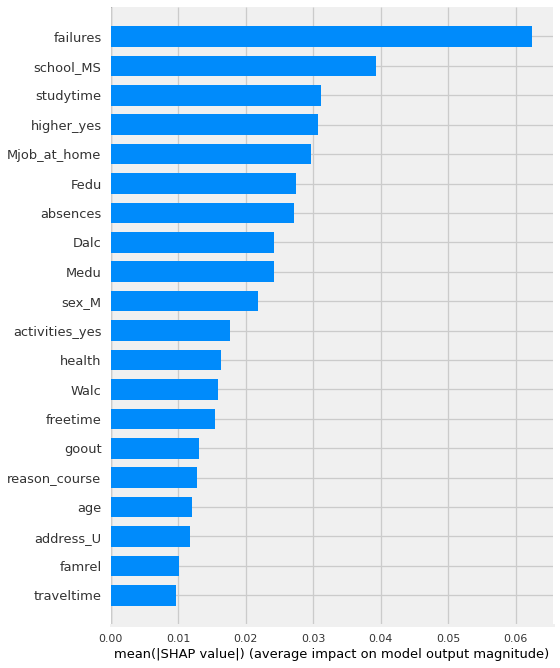

In [34]:
shap.summary_plot(shap_values[:,:,1],features= X_shap,plot_type='bar')

- In this case, it is using the magnitude of the average shap values to to show which features had the biggest impact on the model's predictions.
    - Like feature importance and permutation importance, this visualization is not indicating which **direction** the features push the predict.
    
- Now, let's examine the "dot" version of the summary plot. 
    - By removing the plot_type argument, we are using the default, which is "dot". 
        - We could explicitly specify plot_type="dot".
            - There are also additional plot types that we will not be discussing in this lesson (e.g. "violin","compact_dot")

In [35]:
# shap.summary_plot(shap_values[:,:,1],X_shap)

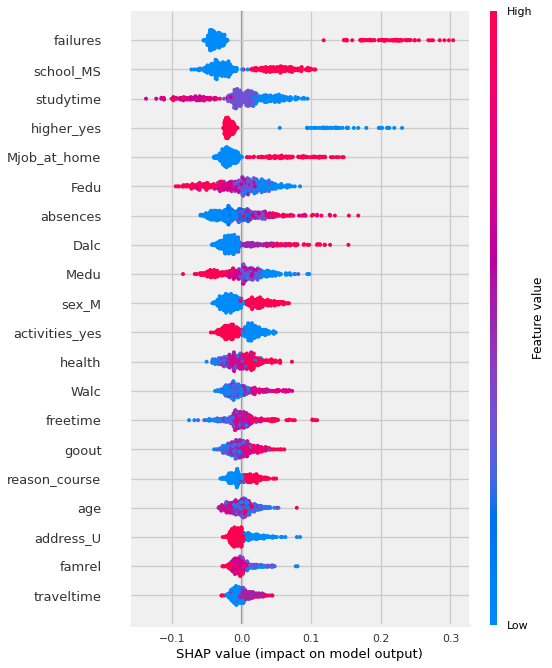

In [36]:
shap.summary_plot(shap_values[:,:,1],X_shap)

TO DO: "Failures""

Now THAT is a lot more nuanced of a visualization!
Let's break down how to interpret the visual above.

In [37]:
# shap.summary_plot(shap_values[:,:,1],features= X_shap,plot_type='compact_dot')

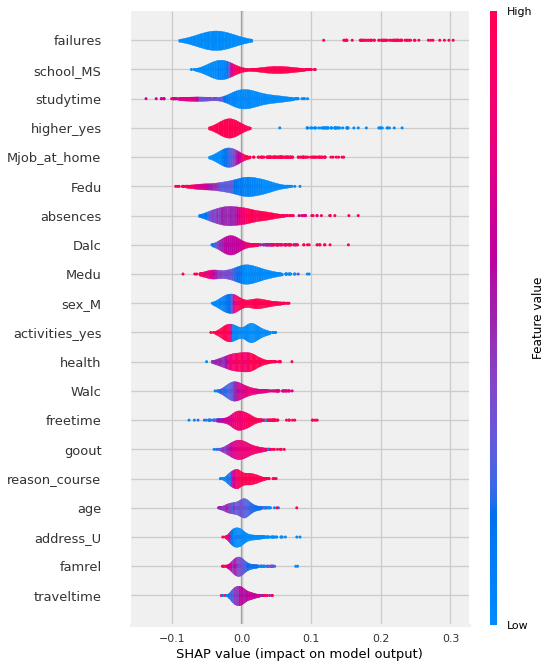

In [38]:
## violin version.
shap.summary_plot(shap_values[:,:,1],features= X_shap,plot_type='violin')

### Dependence Plots


Shap also includes the `shap.dependence_plot`
which show how the model output varies by a specific feature. By passing the function a feature name, it will automatically determine what features may driving the interactions with the selected feature. It will encode the interaction feature as color.
```python
## To Auto-Select Feature Most correlated with a specific feature, just pass the desired feature's column name.

shap.dependence_plot('Age', shap_values[:,:,1], X_shap)
```

- TO DO:
    - There is a way to specifically call out multiple features but I wasn't able to summarize it quickly for this nb
```

In [39]:
# shap_values[:,:,1].values

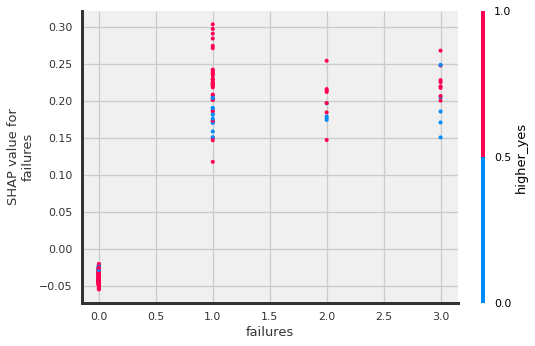

In [40]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("failures", shap_values[:,:,1].values,X_shap)

- ?Men are more likely to have failures?

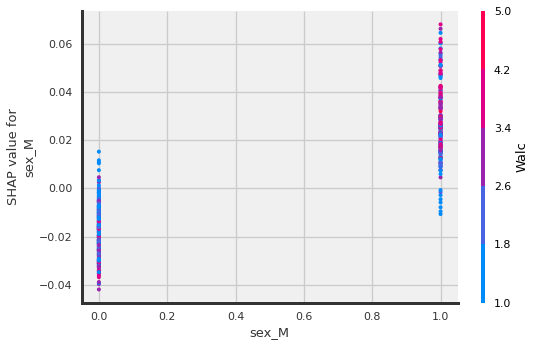

In [41]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("sex_M", shap_values[:,:,1].values,X_shap)

- ?Being male interacts with Weekend alcohol consumption??

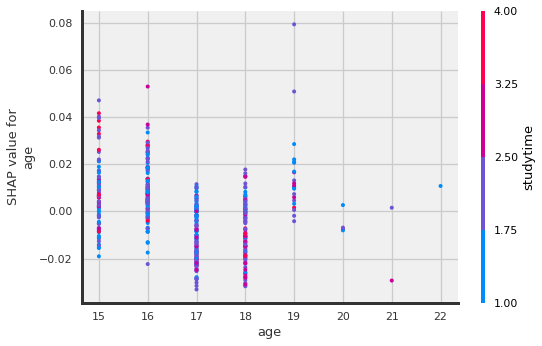

In [42]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("age", shap_values[:,:,1].values,X_shap)

- ?The older the student the more likely the reason for this school was because of a specific course?

### Force Plot

>- Note: the force_plot is an interactive visualization that uses javascript. You must Trust your jupyter notebook in order to display it.
    - In the top right corner of jupyter notebook, next the kernel name (Python (dojo-env)), click the `Not Trusted` button to trust the notebook.

#### Global `shap.force_plot`

To show a global force plot:
```python
## Fore plot
shap.force_plot(explainer.expected_value[1], shap_values[:,:,1], features=X_shap)


```

#### Global Force Plot

In [43]:
## TESTING COMPLEX SHAP VALS AGAIN (Overall Forceplot)
shap.force_plot(explainer.expected_value[1], shap_values[:,:,1].values,features=X_shap)

#### Fore Plot Interpretation

- TO DO

In [44]:
# ## Using explainer.shap_values for easier use of force plot
# shap_vals_simple = explainer.shap_values(X_shap)#,y_test)
# print(type(shap_vals_simple))
# shap_vals_simple[0].shape

In [45]:
# ## Overall Forceplot
# shap.force_plot(explainer.expected_value[1], shap_vals_simple[1],features=X_shap)

#### Explain Individual Plot

- To show an individual data point's prediction and the factors pushing it towards one class or another.
- For now, we will randomly select a row to display, but we will revisit thoughtful selection of examples for stakeholders in our next lesson about local explanations.
```python
## Just using np to randomly select a row
row = np.random.choice(range(len(X_shap)))         
shap.force_plot(explainer.expected_value[1], shap_values[1][row], X_shap.iloc[row])
```

In [46]:
row = np.random.choice(range(len(X_shap)))
print(f"- Row #: {row}")
print(f"- Target: {y_shap.iloc[row]}")
X_shap.iloc[row].round(2)

- Row #: 77
- Target: False


age                  16.0
Medu                  4.0
Fedu                  4.0
traveltime            1.0
studytime             1.0
failures              0.0
famrel                4.0
freetime              4.0
goout                 4.0
Dalc                  1.0
Walc                  2.0
health                2.0
absences              6.0
school_MS             0.0
sex_M                 0.0
address_U             1.0
famsize_LE3           0.0
Pstatus_T             1.0
Mjob_at_home          0.0
Mjob_health           1.0
Mjob_other            0.0
Mjob_services         0.0
Mjob_teacher          0.0
Fjob_at_home          0.0
Fjob_health           0.0
Fjob_other            1.0
Fjob_services         0.0
Fjob_teacher          0.0
reason_course         0.0
reason_home           1.0
reason_other          0.0
reason_reputation     0.0
guardian_father       0.0
guardian_mother       1.0
guardian_other        0.0
schoolsup_yes         0.0
famsup_yes            1.0
paid_yes              0.0
activities_y

In [47]:
# shap_vals_simple[1][row]

In [48]:
## Individual forceplot (with the complex shap vals)
shap.force_plot(explainer.expected_value[1],shap_values= shap_values[row,:,1].values,
               features=X_shap.iloc[row])

In [49]:
# ## Individual forceplot
# shap.force_plot(explainer.expected_value[1],shap_values= shap_vals_simple[1][row],
#                features=X_shap.iloc[row])

### TEST: (move to next lesson)

In [50]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=np.array(X_shap),
    feature_names=X_shap.columns,
    class_names=['Died', 'Survived'],
    mode='classification'
)

exp = lime_explainer.explain_instance(X_shap.iloc[row], rf_clf.predict_proba)
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


### Waterfall Plot

In [51]:
explainer.expected_value

array([0.5367284, 0.4632716])

In [52]:
shap_values[row,:,1]

.values =
array([ 0.00435603, -0.046328  , -0.06670908, -0.00561117,  0.01695354,
       -0.03744232, -0.01199137, -0.0035424 ,  0.0071761 , -0.03123297,
       -0.01183418, -0.03183219,  0.0112064 , -0.04956995, -0.01958825,
       -0.01026708,  0.00046993,  0.0016435 , -0.02908411, -0.00373134,
        0.00057923, -0.00125725, -0.00077366, -0.00136103, -0.00273085,
       -0.00353734, -0.00186776,  0.00090522, -0.01188947, -0.01021466,
       -0.00110236,  0.00028077, -0.00193652,  0.00029861,  0.00066717,
       -0.00965465,  0.00079001, -0.00112643,  0.01878228, -0.00340502,
       -0.02457066, -0.00882573, -0.00436258])

.base_values =
0.4632716049382716

.data =
array([16.,  4.,  4.,  1.,  1.,  0.,  4.,  4.,  4.,  1.,  2.,  2.,  6.,
        0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.])

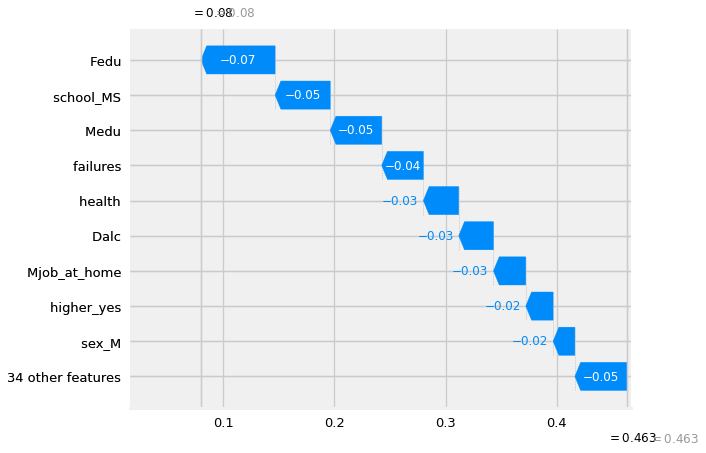

In [53]:
#source: https://towardsdatascience.com/explainable-ai-xai-a-guide-to-7-packages-in-python-to-explain-your-models-932967f0634b
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], 
                                       shap_values[row,:,1].values,
                                       features=X_shap.iloc[row],
                                       show=True)


### Interaction Values

"*The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model’s current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.*"
- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html#Compute-SHAP-Interaction-Values 

- Interactions: - https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

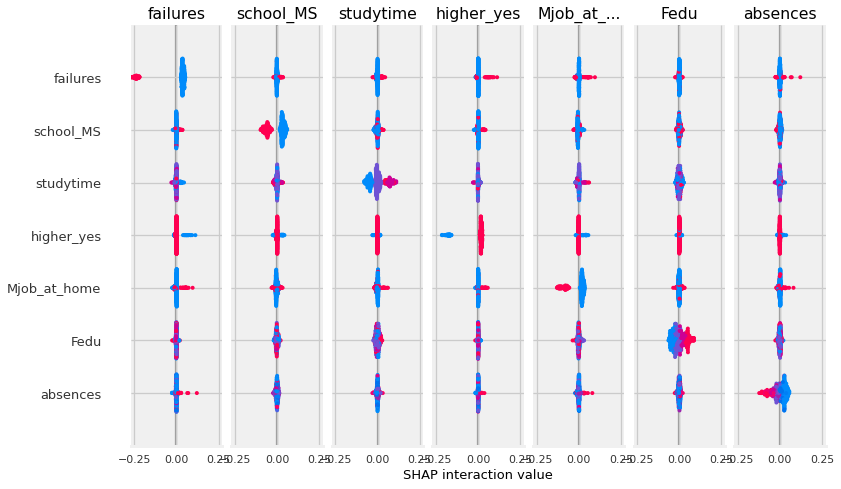

In [54]:
shap_interaction_values = explainer.shap_interaction_values(X_shap)
shap.summary_plot(shap_interaction_values[0],X_shap)

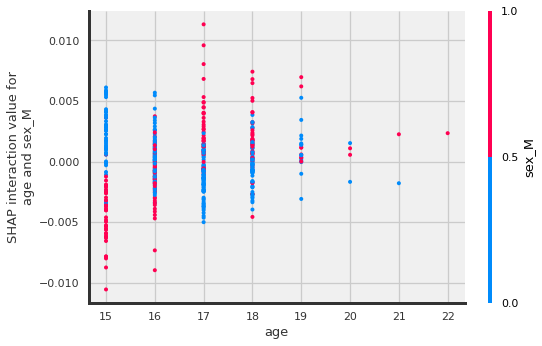

In [55]:
shap.dependence_plot(
    ("age", "sex_M"),
    shap_interaction_values[1], X_shap,
    display_features=X_shap
)

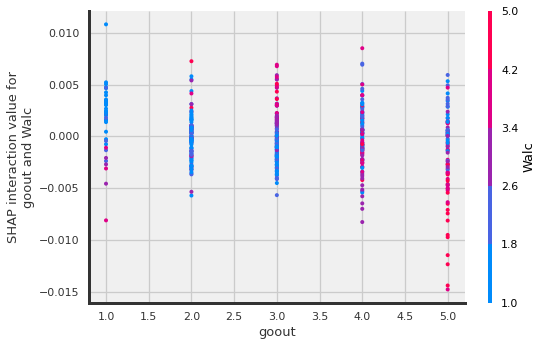

In [56]:
shap.dependence_plot(
    ("goout", "Walc"),
    shap_interaction_values[1], X_shap,
    display_features=X_shap
)

>- **The more the student goes out, the higher the Walc, and ...(a negative shap interaction value would mean....🤔) `BOOKMARK`**

> TO DO: read more about the interactions and add interpretation here


## `Shap Decision Plot?`
- https://slundberg.github.io/shap/notebooks/plots/decision_plot.html

In [75]:
X_shap.loc[( X_shap['sex_M']==1) & (X_shap['Medu']>3) & (X_shap['goout']>2)\
          & (X_shap['reason_course']==1)]


age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
13   15.0   4.0   3.0         2.0        2.0       0.0     5.0       4.0   
42   15.0   4.0   4.0         1.0        2.0       0.0     4.0       3.0   
71   15.0   4.0   2.0         1.0        4.0       0.0     3.0       3.0   
128  16.0   4.0   4.0         1.0        1.0       0.0     3.0       5.0   
193  17.0   4.0   3.0         1.0        2.0       0.0     5.0       2.0   
102  15.0   4.0   4.0         1.0        1.0       0.0     5.0       3.0   
268  17.0   4.0   4.0         2.0        2.0       0.0     3.0       3.0   
267  17.0   4.0   3.0         2.0        2.0       0.0     2.0       5.0   
543  17.0   4.0   4.0         3.0        1.0       3.0     3.0       3.0   
501  16.0   4.0   3.0         1.0        1.0       0.0     4.0       2.0   
361  19.0   4.0   2.0         2.0        2.0       0.0     5.0       4.0   
76   15.0   4.0   0.0         2.0        4.0       0.0     3.0       4.0   
12   15.0   4.0   4.0         1.0        1.0       0.0     4.0       3.0   
189  17.0   4.0   3.0         2.0        2.0       0.0     4.0       4.0   
401  18.0   4.0   3.0         1.0        3.0       0.0     5.0       4.0   

     goout  Dalc  Walc  health  absences  school_MS  sex_M  address_U  \
13     3.0   1.0   2.0     3.0       0.0        0.0    1.0        1.0   
42     3.0   1.0   1.0     5.0       0.0        0.0    1.0        1.0   
71     3.0   1.0   1.0     3.0       0.0        0.0    1.0        1.0   
128    5.0   2.0   5.0     4.0       8.0        0.0    1.0        0.0   
193    3.0   1.0   1.0     2.0       4.0        0.0    1.0        1.0   
102    3.0   1.0   1.0     5.0       2.0        0.0    1.0        1.0   
268    3.0   2.0   3.0     4.0       0.0        0.0    1.0        0.0   
267    5.0   1.0   4.0     5.0       8.0        0.0    1.0        1.0   
543    3.0   1.0   3.0     5.0       2.0        1.0    1.0        0.0   
501    5.0   1.0   5.0     5.0       8.0        1.0    1.0        1.0   
361    4.0   1.0   1.0     1.0       9.0        0.0    1.0        1.0   
76     3.0   1.0   1.0     1.0       0.0        0.0    1.0        1.0   
12     3.0   1.0   3.0     5.0       0.0        0.0    1.0        1.0   
189    4.0   4.0   4.0     4.0       0.0        0.0    1.0        1.0   
401    5.0   2.0   3.0     5.0       0.0        0.0    1.0        1.0   

     famsize_LE3  Pstatus_T  Mjob_at_home  Mjob_health  Mjob_other  \
13           0.0        1.0           0.0          0.0         0.0   
42           0.0        1.0           0.0          0.0         0.0   
71           0.0        1.0           0.0          0.0         1.0   
128          0.0        1.0           0.0          0.0         0.0   
193          0.0        1.0           0.0          0.0         1.0   
102          0.0        1.0           0.0          0.0         0.0   
268          1.0        0.0           0.0          0.0         0.0   
267          1.0        1.0           0.0          1.0         0.0   
543          0.0        1.0           0.0          1.0         0.0   
501          1.0        1.0           0.0          0.0         1.0   
361          0.0        1.0           0.0          1.0         0.0   
76           0.0        1.0           0.0          0.0         0.0   
12           1.0        1.0           0.0          1.0         0.0   
189          1.0        1.0           0.0          0.0         0.0   
401          0.0        1.0           0.0          0.0         0.0   

     Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  Fjob_other  \
13             0.0           1.0           0.0          0.0         1.0   
42             1.0           0.0           0.0          0.0         0.0   
71             0.0           0.0           0.0          0.0         1.0   
128            0.0           1.0           0.0          0.0         0.0   
193            0.0           0.0           0.0          0.0         1.0   
102            1.0           0.0           0.0   

In [71]:
X_shap['goout']

54     4.0
208    3.0
23     4.0
547    2.0
604    2.0
      ... 
410    4.0
168    4.0
401    5.0
124    4.0
538    3.0
Name: goout, Length: 486, dtype: float64

In [76]:
example = 13


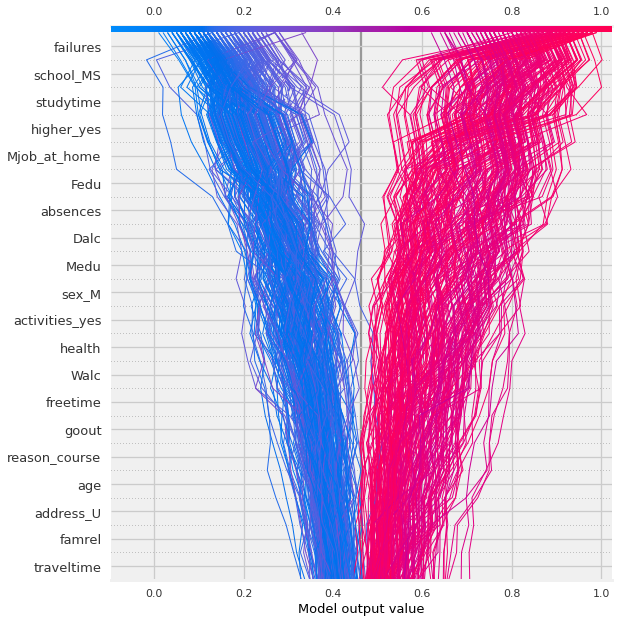

In [77]:
shap.decision_plot(explainer.expected_value[1], shap_values[:,:,1].values,X_shap,
                  highlight=example)

## 📌 TO DO

- Try more targets. 
    - Combine D and F into 1 group
    - Make a target about decrease in performance from g1 to g3.

# APPENDIX

In [58]:
raise Exception('Do not include below in run all.')

Exception: Do not include below in run all.

## Lesson Creation Code

In [ ]:
# [o for o in dir(shap) if 'Explainer' in o]

In [ ]:
import pandas as pd
tables = pd.read_html("https://shap.readthedocs.io/en/latest/api.html")
len(tables)

In [ ]:
explainers = tables[1]#.style.hide('index')
explainers.columns = ['Explainer','Description']
explainers['Explainer'] = explainers['Explainer'].map(lambda x: x.split('(')[0])
explainers

In [ ]:
print(explainers.set_index("Explainer").to_markdown())